## Check GPU presence

In [1]:
import sys
print(sys.executable)
print(sys.version)

#import sys
#!{sys.executable} -m pip uninstall torch torchvision torchaudio -y
#!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import torch
import torchvision

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

C:\Users\aaron\AppData\Local\Programs\Python\Python311\python.exe
3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
PyTorch: 2.5.1+cu121
Torchvision: 0.20.1+cu121
CUDA available: True


In [2]:
from torch.utils.data import Dataset

# Custom Dataset class
class ChipDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Add dtype=torch.long
        return image, label

## Collect / analyze image database

Collect all images in the database, count the number of samples in each brand, and present in a plot. For this model, each model must have a minimum of 20 images to be used.


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\aaron\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip --quiet


Found 929 total images across 100 brands

Total images for training: 562


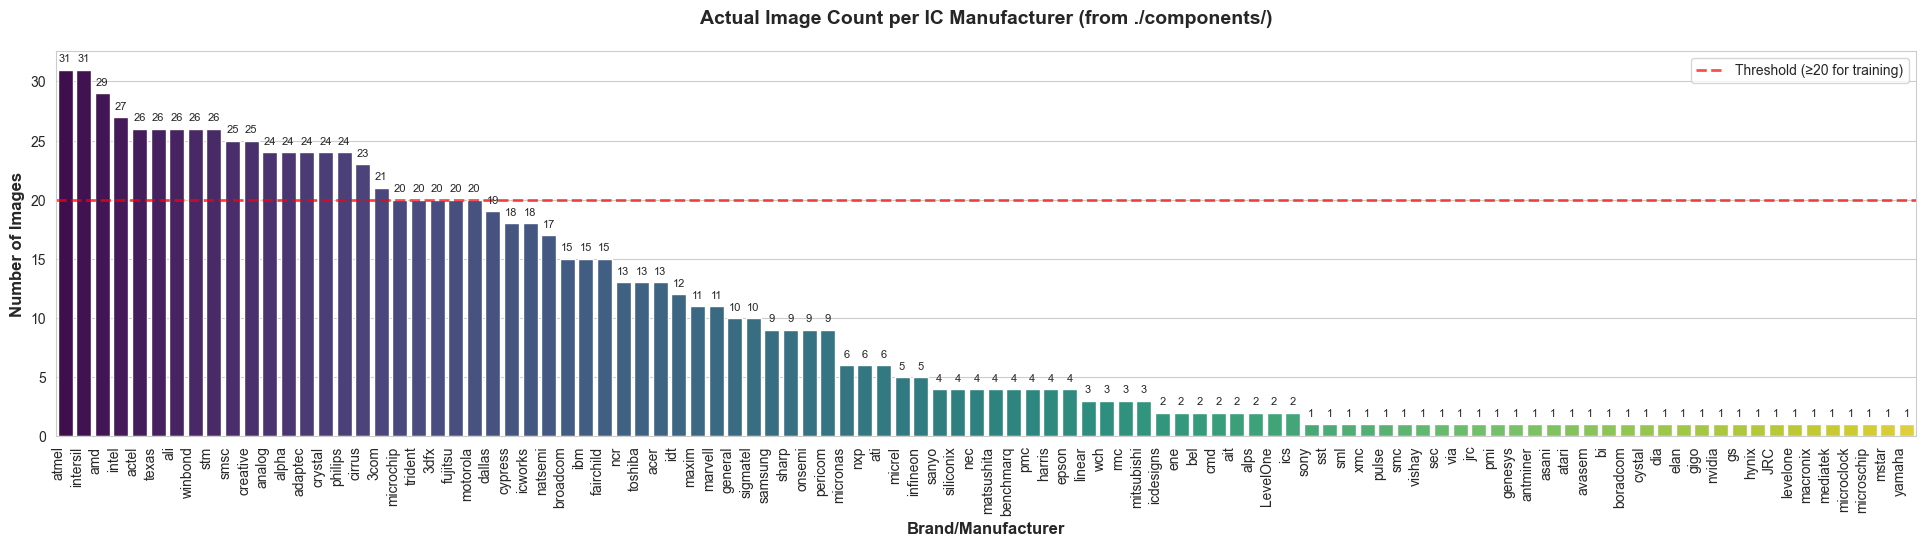

In [3]:
!pip install --upgrade pip --quiet

# Section 1: Data Augmentation & Dataset Setup
import os
from PIL import Image
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Define your data directory
DATA_DIR = './components/'

# Scan the directory and build the dataset directly from files
brand_counts = Counter()
all_files = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith('.png'):
        brand = filename.split('_')[0]
        brand_counts[brand] += 1
        all_files.append(filename)

# Create dataframe from actual files
df = pd.DataFrame([
    {'Brand': brand, 'Moniker': brand, 'Count': count}
    for brand, count in brand_counts.items()
]).sort_values('Count', ascending=False)

print(f"Found {len(all_files)} total images across {len(df)} brands")

# Create visualization
plt.figure(figsize=(24, 5))
sns.set_style("whitegrid")

# Create bar plot
ax = sns.barplot(data=df, x='Brand', y='Count', hue='Brand', palette='viridis', legend=False)

# Customize the plot
plt.xticks(rotation=90, ha='right')
plt.xlabel('Brand/Manufacturer', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Actual Image Count per IC Manufacturer (from ./components/)', fontsize=14, fontweight='bold', pad=20)

# Add value labels on top of bars
for i, v in enumerate(df['Count']):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)

# Add threshold line
plt.axhline(y=20, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (≥20 for training)')
plt.legend()


# Filter to brands with >= 20 images
min_df = df[df['Count'] >= 20].copy()

# Get list of valid brands (these will be your classes)
valid_brands = min_df['Moniker'].tolist()
brand_to_idx = {brand: idx for idx, brand in enumerate(sorted(valid_brands))}
idx_to_brand = {idx: brand for brand, idx in brand_to_idx.items()}

# Collect all valid images (only from brands with >= 20 images)
image_paths = []
labels = []

for filename in all_files:
    brand = filename.split('_')[0]
    
    if brand in brand_to_idx:
        image_paths.append(os.path.join(DATA_DIR, filename))
        labels.append(brand_to_idx[brand])

print(f"\nTotal images for training: {len(image_paths)}")

## Reduce dataset to minimum viable brands

To be used in the model, each brand must contain a minimum of 20 samples. Brands with less than 20 samples are discarded from the dataset.

In [4]:
# Section 3: Download/Build the Model
import torch.nn as nn
from torchvision import models

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Load pretrained ResNet-18
print(f"\n{'='*60}")
print("Loading ResNet-18 with ImageNet pretrained weights...")

model = models.resnet18(pretrained=True)

# Freeze early layers (optional - keeps ImageNet features)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_classes = len(brand_to_idx)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU/CPU
model = model.to(device)

print(f"Model architecture modified:")
print(f"  Original output: 1000 classes (ImageNet)")
print(f"  New output: {num_classes} classes (IC brands)")
print(f"  Frozen layers: Early conv layers (transfer learning)")
print(f"  Trainable layers: Final FC layer")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

print(f"\nTraining configuration:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"\nModel ready for training!")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memory: 6.00 GB

Loading ResNet-18 with ImageNet pretrained weights...


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model architecture modified:
  Original output: 1000 classes (ImageNet)
  New output: 20 classes (IC brands)
  Frozen layers: Early conv layers (transfer learning)
  Trainable layers: Final FC layer

Model parameters:
  Total parameters: 11,186,772
  Trainable parameters: 10,260
  Frozen parameters: 11,176,512

Training configuration:
  Loss function: CrossEntropyLoss
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)

Model ready for training!


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Split dataset into train / test / validation (80 / (80/20))

In [5]:
# Section 2: Train/Test/Validation Split
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import transforms

# Convert to numpy arrays for easier manipulation
image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Total dataset: {len(image_paths)} images")
print(f"Number of classes: {len(brand_to_idx)}")

# First split: 80% train+val, 20% test
# Stratify to ensure each brand is represented proportionally in each split
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, 
    labels, 
    test_size=0.2,  # 20% for test
    stratify=labels,  # Maintain class distribution
    random_state=42
)

# Second split: Split train+val into 80% train, 20% val
# From the remaining 80%, take 20% for validation (which is 16% of total)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths,
    train_val_labels,
    test_size=0.2,  # 20% of train_val = 16% of total
    stratify=train_val_labels,
    random_state=42
)

# Final split: ~64% train, ~16% val, ~20% test
print(f"\n{'='*60}")
print(f"Split Summary:")
print(f"  Training:   {len(train_paths)} images ({len(train_paths)/len(image_paths)*100:.1f}%)")
print(f"  Validation: {len(val_paths)} images ({len(val_paths)/len(image_paths)*100:.1f}%)")
print(f"  Test:       {len(test_paths)} images ({len(test_paths)/len(image_paths)*100:.1f}%)")

# Verify stratification - check distribution across splits
print(f"\n{'='*60}")
print(f"Verifying stratification (samples per brand):")
print(f"{'Brand':<15} {'Train':<8} {'Val':<8} {'Test':<8} {'Total':<8}")
print(f"{'-'*60}")

for brand in sorted(valid_brands):
    brand_idx = brand_to_idx[brand]
    train_count = np.sum(train_labels == brand_idx)
    val_count = np.sum(val_labels == brand_idx)
    test_count = np.sum(test_labels == brand_idx)
    total = train_count + val_count + test_count
    print(f"{brand:<15} {train_count:<8} {val_count:<8} {test_count:<8} {total:<8}")

# Training augmentations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test augmentations
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with appropriate transforms
train_dataset = ChipDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = ChipDataset(val_paths, val_labels, transform=val_test_transforms)
test_dataset = ChipDataset(test_paths, test_labels, transform=val_test_transforms)

print(f"\n{'='*60}")
print(f"Datasets created:")
print(f"  Training dataset:   {len(train_dataset)} samples (with augmentation)")
print(f"  Validation dataset: {len(val_dataset)} samples (no augmentation)")
print(f"  Test dataset:       {len(test_dataset)} samples (no augmentation)")

# Create data loaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Changed from 4 to 0 (Windows fix)
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Changed from 4 to 0
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Changed from 4 to 0
    pin_memory=True
)

print(f"\nDataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches:   {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches:       {len(test_loader)}")

Total dataset: 484 images
Number of classes: 20

Split Summary:
  Training:   309 images (63.8%)
  Validation: 78 images (16.1%)
  Test:       97 images (20.0%)

Verifying stratification (samples per brand):
Brand           Train    Val      Test     Total   
------------------------------------------------------------
3dfx            13       3        4        20      
actel           17       4        5        26      
adaptec         15       4        5        24      
ali             17       4        5        26      
amd             18       5        6        29      
analog          15       4        5        24      
cirrus          14       4        5        23      
creative        16       4        5        25      
crystal         15       4        5        24      
fujitsu         13       3        4        20      
intel           17       5        5        27      
intersil        20       5        6        31      
microchip       13       3        4        20      
mot

## Implement transfer learning model (Resnet-18)

In [6]:
# Section 3: Download/Build the Model (FIXED)
import torch
import torch.nn as nn
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

print(f"\n{'='*60}")
print("Loading ResNet-18 with ImageNet pretrained weights...")

model = models.resnet18(pretrained=True)

# CHANGE: Only freeze early conv layers (layer1, layer2)
# Keep layer3, layer4, and fc unfrozen for fine-tuning
for name, param in model.named_parameters():
    if 'layer1' in name or 'layer2' in name or 'conv1' in name or 'bn1' in name:
        param.requires_grad = False
    else:
        param.requires_grad = True  # Unfreeze layer3, layer4, fc

# Replace final FC layer
num_classes = len(brand_to_idx)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move to GPU
model = model.to(device)

print(f"Model architecture modified:")
print(f"  Output classes: {num_classes}")
print(f"  Frozen: conv1, bn1, layer1, layer2 (early features)")
print(f"  Trainable: layer3, layer4, fc (fine-tuning)")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Frozen: {total_params - trainable_params:,}")

# Define loss and optimizer - NOW optimizing ALL unfrozen parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # All trainable params
    lr=0.0001  # Lower learning rate for fine-tuning
)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

print(f"\nTraining configuration:")
print(f"  Loss: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr=0.0001)")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"\nModel ready for training!")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memory: 6.00 GB

Loading ResNet-18 with ImageNet pretrained weights...
Model architecture modified:
  Output classes: 20
  Frozen: conv1, bn1, layer1, layer2 (early features)
  Trainable: layer3, layer4, fc (fine-tuning)

Model parameters:
  Total: 11,186,772
  Trainable: 6,076,948
  Frozen: 5,109,824

Training configuration:
  Loss: CrossEntropyLoss
  Optimizer: Adam (lr=0.0001)
  Scheduler: ReduceLROnPlateau

Model ready for training!


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Run model

In [7]:
# Section 4: Training Loop with Progress Monitoring
import time
from tqdm import tqdm

# Training configuration
NUM_EPOCHS = 20  # Adjust based on your needs
BEST_MODEL_PATH = 'best_chip_classifier.pth'

# Tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"{'='*60}\n")

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    
    # ================== TRAINING PHASE ==================
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar for training
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    
    for images, labels_batch in train_pbar:
        # Move data to GPU
        images = images.to(device)
        labels_batch = labels_batch.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()
        
        # Update progress bar
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # ================== VALIDATION PHASE ==================
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Progress bar for validation
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Val]  ')
    
    with torch.no_grad():  # No gradient calculation during validation
        for images, labels_batch in val_pbar:
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels_batch.size(0)
            val_correct += (predicted == labels_batch).sum().item()
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * val_correct / val_total:.2f}%'
            })
    
    # Calculate validation metrics
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f'\n✓ New best model saved! Val Acc: {val_acc:.2f}%')
    
    # Epoch summary
    epoch_time = time.time() - epoch_start_time
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS} Summary:')
    print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
    print(f'  Time: {epoch_time:.2f}s')
    print(f'{"-"*60}\n')

print(f'\n{"="*60}')
print(f'Training Complete!')
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
print(f'Model saved to: {BEST_MODEL_PATH}')

Starting training for 20 epochs...



Epoch 1/20 [Val]  : 100%|███████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=2.7571, acc=14.10%]



✓ New best model saved! Val Acc: 14.10%

Epoch 1/20 Summary:
  Train Loss: 2.9951 | Train Acc: 11.65%
  Val Loss:   2.8594 | Val Acc:   14.10%
  Time: 8.64s
------------------------------------------------------------



Epoch 2/20 [Val]  : 100%|███████████████████| 3/3 [00:00<00:00,  4.94it/s, loss=2.3280, acc=20.51%]



✓ New best model saved! Val Acc: 20.51%

Epoch 2/20 Summary:
  Train Loss: 2.4931 | Train Acc: 31.39%
  Val Loss:   2.5742 | Val Acc:   20.51%
  Time: 6.02s
------------------------------------------------------------



Epoch 3/20 [Val]  : 100%|███████████████████| 3/3 [00:00<00:00,  4.86it/s, loss=2.0031, acc=25.64%]



✓ New best model saved! Val Acc: 25.64%

Epoch 3/20 Summary:
  Train Loss: 2.1377 | Train Acc: 46.93%
  Val Loss:   2.3656 | Val Acc:   25.64%
  Time: 6.08s
------------------------------------------------------------



Epoch 4/20 [Val]  : 100%|███████████████████| 3/3 [00:00<00:00,  3.29it/s, loss=1.8022, acc=35.90%]



✓ New best model saved! Val Acc: 35.90%

Epoch 4/20 Summary:
  Train Loss: 1.8236 | Train Acc: 60.84%
  Val Loss:   2.1967 | Val Acc:   35.90%
  Time: 6.43s
------------------------------------------------------------



Epoch 5/20 [Val]  : 100%|███████████████████| 3/3 [00:00<00:00,  3.64it/s, loss=1.5991, acc=35.90%]



Epoch 5/20 Summary:
  Train Loss: 1.5384 | Train Acc: 68.93%
  Val Loss:   2.0516 | Val Acc:   35.90%
  Time: 6.09s
------------------------------------------------------------



Epoch 6/20 [Val]  : 100%|███████████████████| 3/3 [00:00<00:00,  4.09it/s, loss=1.4727, acc=43.59%]



✓ New best model saved! Val Acc: 43.59%

Epoch 6/20 Summary:
  Train Loss: 1.3460 | Train Acc: 77.02%
  Val Loss:   1.9369 | Val Acc:   43.59%
  Time: 6.14s
------------------------------------------------------------



Epoch 7/20 [Val]  : 100%|███████████████████| 3/3 [00:00<00:00,  4.16it/s, loss=1.3484, acc=52.56%]



✓ New best model saved! Val Acc: 52.56%

Epoch 7/20 Summary:
  Train Loss: 1.1284 | Train Acc: 81.55%
  Val Loss:   1.8364 | Val Acc:   52.56%
  Time: 5.99s
------------------------------------------------------------



Epoch 8/20 [Val]  : 100%|███████████████████| 3/3 [00:00<00:00,  4.89it/s, loss=1.2402, acc=56.41%]



✓ New best model saved! Val Acc: 56.41%

Epoch 8/20 Summary:
  Train Loss: 1.0076 | Train Acc: 85.44%
  Val Loss:   1.7247 | Val Acc:   56.41%
  Time: 6.21s
------------------------------------------------------------



Epoch 9/20 [Val]  : 100%|███████████████████| 3/3 [00:00<00:00,  4.85it/s, loss=1.1612, acc=55.13%]



Epoch 9/20 Summary:
  Train Loss: 0.8509 | Train Acc: 87.70%
  Val Loss:   1.6555 | Val Acc:   55.13%
  Time: 6.03s
------------------------------------------------------------



Epoch 10/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.50it/s, loss=1.0883, acc=57.69%]



✓ New best model saved! Val Acc: 57.69%

Epoch 10/20 Summary:
  Train Loss: 0.6994 | Train Acc: 93.85%
  Val Loss:   1.5989 | Val Acc:   57.69%
  Time: 6.12s
------------------------------------------------------------



Epoch 11/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.68it/s, loss=1.0425, acc=58.97%]



✓ New best model saved! Val Acc: 58.97%

Epoch 11/20 Summary:
  Train Loss: 0.5905 | Train Acc: 94.82%
  Val Loss:   1.5484 | Val Acc:   58.97%
  Time: 6.45s
------------------------------------------------------------



Epoch 12/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.13it/s, loss=0.9848, acc=58.97%]



Epoch 12/20 Summary:
  Train Loss: 0.5044 | Train Acc: 97.09%
  Val Loss:   1.4940 | Val Acc:   58.97%
  Time: 6.21s
------------------------------------------------------------



Epoch 13/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.43it/s, loss=0.9226, acc=60.26%]



✓ New best model saved! Val Acc: 60.26%

Epoch 13/20 Summary:
  Train Loss: 0.4039 | Train Acc: 97.41%
  Val Loss:   1.4618 | Val Acc:   60.26%
  Time: 6.09s
------------------------------------------------------------



Epoch 14/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.86it/s, loss=0.8740, acc=61.54%]



✓ New best model saved! Val Acc: 61.54%

Epoch 14/20 Summary:
  Train Loss: 0.3767 | Train Acc: 97.09%
  Val Loss:   1.4275 | Val Acc:   61.54%
  Time: 6.16s
------------------------------------------------------------



Epoch 15/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.48it/s, loss=0.8689, acc=60.26%]



Epoch 15/20 Summary:
  Train Loss: 0.3164 | Train Acc: 98.06%
  Val Loss:   1.4163 | Val Acc:   60.26%
  Time: 5.88s
------------------------------------------------------------



Epoch 16/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.40it/s, loss=0.8437, acc=60.26%]



Epoch 16/20 Summary:
  Train Loss: 0.2636 | Train Acc: 98.71%
  Val Loss:   1.3832 | Val Acc:   60.26%
  Time: 6.10s
------------------------------------------------------------



Epoch 17/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.02it/s, loss=0.8659, acc=58.97%]



Epoch 17/20 Summary:
  Train Loss: 0.2328 | Train Acc: 99.03%
  Val Loss:   1.3768 | Val Acc:   58.97%
  Time: 6.10s
------------------------------------------------------------



Epoch 18/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.06it/s, loss=0.8310, acc=61.54%]



Epoch 18/20 Summary:
  Train Loss: 0.1958 | Train Acc: 99.68%
  Val Loss:   1.3416 | Val Acc:   61.54%
  Time: 6.53s
------------------------------------------------------------



Epoch 19/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.27it/s, loss=0.7995, acc=62.82%]



✓ New best model saved! Val Acc: 62.82%

Epoch 19/20 Summary:
  Train Loss: 0.1831 | Train Acc: 99.68%
  Val Loss:   1.3231 | Val Acc:   62.82%
  Time: 6.28s
------------------------------------------------------------



Epoch 20/20 [Val]  : 100%|██████████████████| 3/3 [00:00<00:00,  4.21it/s, loss=0.8021, acc=64.10%]



✓ New best model saved! Val Acc: 64.10%

Epoch 20/20 Summary:
  Train Loss: 0.1569 | Train Acc: 99.35%
  Val Loss:   1.3164 | Val Acc:   64.10%
  Time: 6.21s
------------------------------------------------------------


Training Complete!
Best Validation Accuracy: 64.10%
Model saved to: best_chip_classifier.pth


C:\Users\aaron\AppData\Local\Temp\ipykernel_16880\2037999590.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH))


Loading best model for evaluation...

EVALUATING ON TEST SET

TEST SET PERFORMANCE
Accuracy:           60.82%
F1 Score (Macro):   0.5934
F1 Score (Weighted): 0.5895

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        3dfx      1.000     1.000     1.000         4
       actel      0.556     1.000     0.714         5
     adaptec      0.714     1.000     0.833         5
         ali      1.000     1.000     1.000         5
         amd      0.556     0.833     0.667         6
      analog      0.667     0.400     0.500         5
      cirrus      0.833     1.000     0.909         5
    creative      0.600     0.600     0.600         5
     crystal      0.800     0.800     0.800         5
     fujitsu      0.333     0.250     0.286         4
       intel      0.750     0.600     0.667         5
    intersil      0.250     0.167     0.200         6
   microchip      0.500     0.500     0.500         4
    motorola      0.667     0.500     0.571   

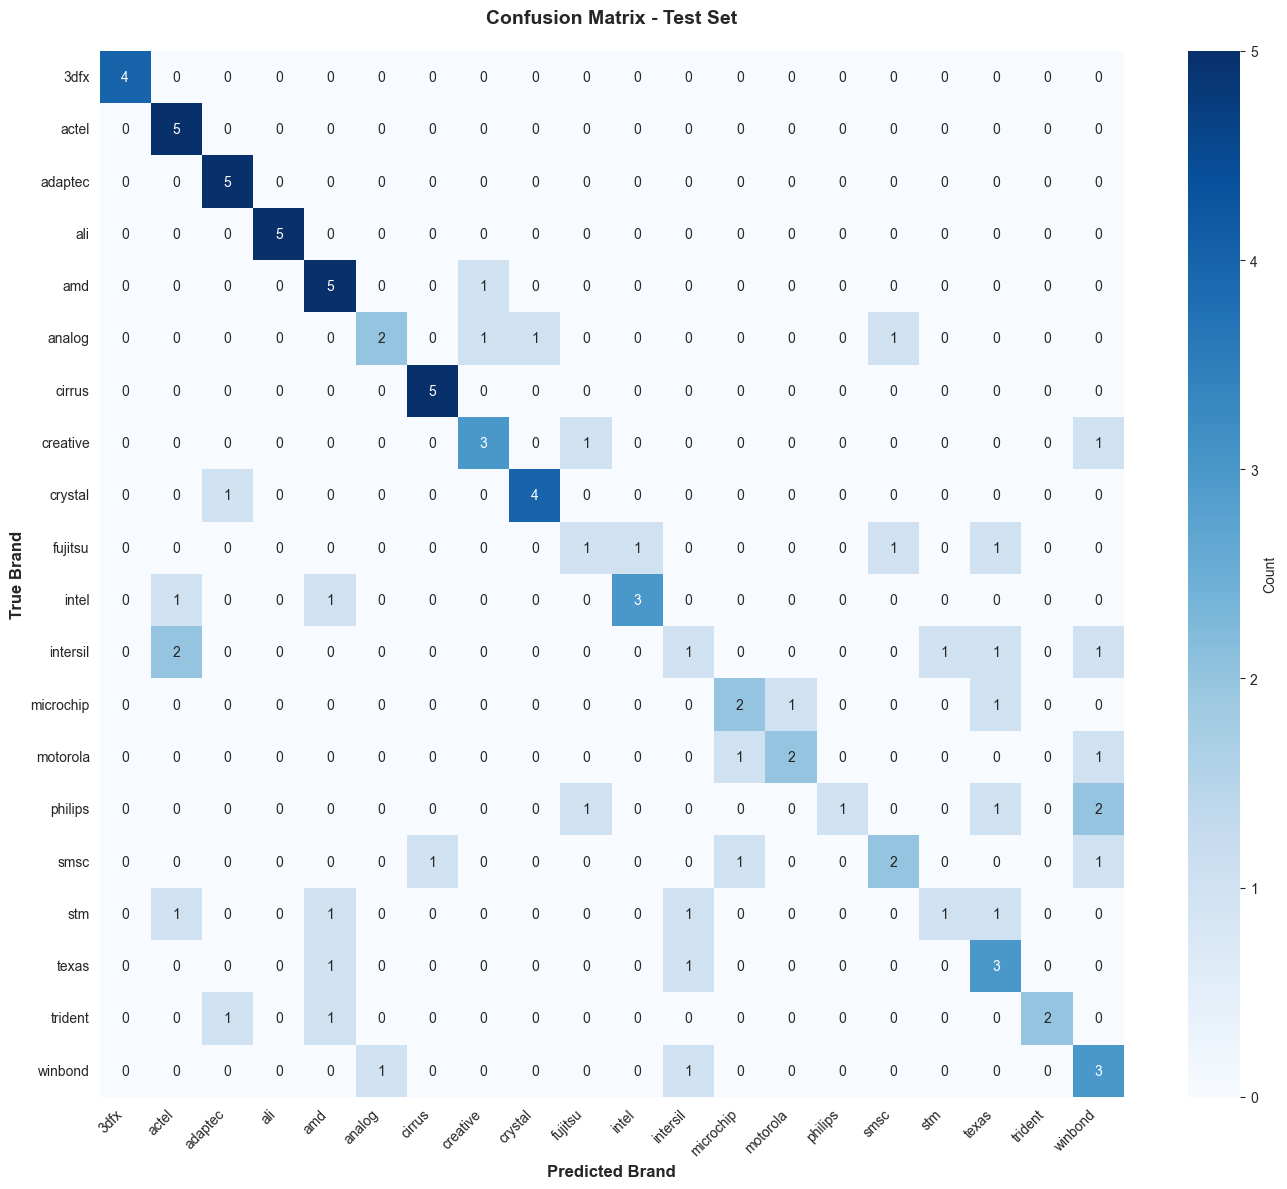


Confusion matrix saved as 'confusion_matrix.png'

PER-CLASS ACCURACY
3dfx                 100.00%  (4 samples)
actel                100.00%  (5 samples)
adaptec              100.00%  (5 samples)
ali                  100.00%  (5 samples)
amd                   83.33%  (6 samples)
analog                40.00%  (5 samples)
cirrus               100.00%  (5 samples)
creative              60.00%  (5 samples)
crystal               80.00%  (5 samples)
fujitsu               25.00%  (4 samples)
intel                 60.00%  (5 samples)
intersil              16.67%  (6 samples)
microchip             50.00%  (4 samples)
motorola              50.00%  (4 samples)
philips               20.00%  (5 samples)
smsc                  40.00%  (5 samples)
stm                   20.00%  (5 samples)
texas                 60.00%  (5 samples)
trident               50.00%  (4 samples)
winbond               60.00%  (5 samples)


In [8]:
# Section 5: Performance Metrics and Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load best model
print("Loading best model for evaluation...")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

# Evaluate on TEST set
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels_batch in test_loader:
        images = images.to(device)
        labels_batch = labels_batch.to(device)
        
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
test_accuracy = accuracy_score(all_labels, all_preds)
test_f1_macro = f1_score(all_labels, all_preds, average='macro')
test_f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print(f"\n{'='*60}")
print("TEST SET PERFORMANCE")
print(f"{'='*60}")
print(f"Accuracy:           {test_accuracy*100:.2f}%")
print(f"F1 Score (Macro):   {test_f1_macro:.4f}")
print(f"F1 Score (Weighted): {test_f1_weighted:.4f}")

# Detailed classification report
print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*60}")

# Get brand names for report
brand_names = [idx_to_brand[i] for i in range(len(brand_to_idx))]

report = classification_report(
    all_labels, 
    all_preds, 
    target_names=brand_names,
    digits=3
)
print(report)

# Confusion Matrix
print(f"\n{'='*60}")
print("CONFUSION MATRIX")
print(f"{'='*60}")

cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=brand_names,
    yticklabels=brand_names,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Brand', fontsize=12, fontweight='bold')
plt.ylabel('True Brand', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved as 'confusion_matrix.png'")

# Per-class accuracy
print(f"\n{'='*60}")
print("PER-CLASS ACCURACY")
print(f"{'='*60}")

for i, brand in enumerate(brand_names):
    brand_mask = all_labels == i
    if brand_mask.sum() > 0:
        brand_acc = (all_preds[brand_mask] == all_labels[brand_mask]).mean()
        n_samples = brand_mask.sum()
        print(f"{brand:<20} {brand_acc*100:>6.2f}%  ({n_samples} samples)")

Generating attention maps for test samples...


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
C:\Users\aaron\AppData\Local\Temp\ipykernel_16880\4067888796.py:132: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aaron\AppData\Local\Temp\ipykernel_16880\4067888796.py:132: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aaron\AppData\Local\Temp\ipykernel_16880\4067888796.py:133: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('attention_maps.png', dpi=300, bbox_inches='tight')
C:\Users\aaron\AppData\Local\Temp\ipykerne

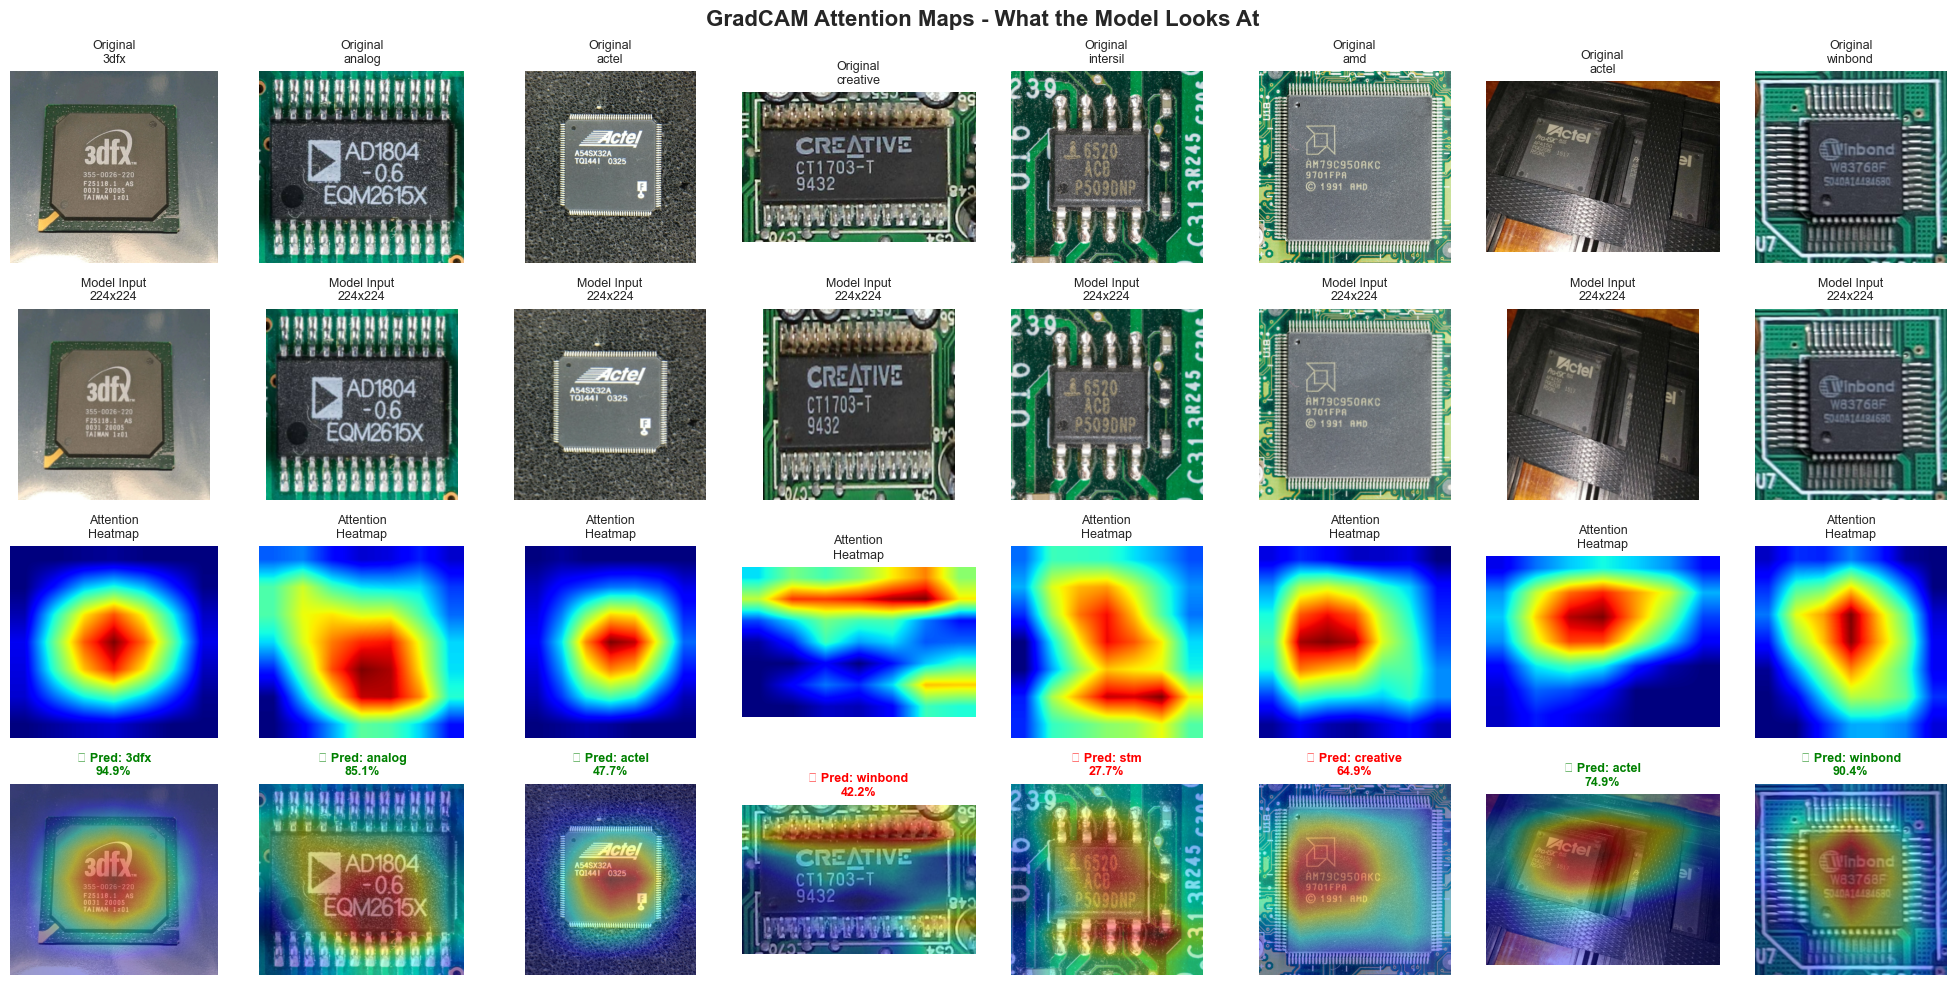


Attention maps saved as 'attention_maps.png'

Interpretation Guide:
- Red/Yellow areas: High attention (model focuses here)
- Blue/Purple areas: Low attention (model ignores)
- The model should focus on LOGOS for correct predictions


In [9]:
# Section 6: Attention Maps using GradCAM
import cv2
from PIL import Image
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        class_loss = model_output[0, target_class]
        class_loss.backward()
        
        # Get gradients and activations
        gradients = self.gradients[0]  # [C, H, W]
        activations = self.activations[0]  # [C, H, W]
        
        # Global average pooling on gradients
        weights = gradients.mean(dim=(1, 2))  # [C]
        
        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32).to(device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # ReLU and normalize
        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.cpu().numpy()

# Initialize GradCAM with layer4 (last conv layer before FC)
gradcam = GradCAM(model, model.layer4[-1].conv2)

# Generate attention maps for random test samples
print("Generating attention maps for test samples...")
print("="*60)

num_samples = 8  # Number of samples to visualize
fig, axes = plt.subplots(4, num_samples, figsize=(20, 10))
fig.suptitle('GradCAM Attention Maps - What the Model Looks At', fontsize=16, fontweight='bold')

# Randomly sample from test set
import random
sample_indices = random.sample(range(len(test_paths)), num_samples)

for col, idx in enumerate(sample_indices):
    img_path = test_paths[idx]
    true_label = test_labels[idx]
    true_brand = idx_to_brand[true_label]
    
    # Load and preprocess image
    img_orig = Image.open(img_path).convert('RGB')
    img_tensor = val_test_transforms(img_orig).unsqueeze(0).to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        pred_prob, pred_label = torch.max(probs, 1)
        pred_brand = idx_to_brand[pred_label.item()]
    
    # Generate GradCAM
    cam = gradcam.generate_cam(img_tensor, pred_label.item())
    
    # Resize CAM to original image size
    cam_resized = cv2.resize(cam, img_orig.size)
    
    # Convert original image to numpy
    img_np = np.array(img_orig) / 255.0
    
    # Create heatmap overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Superimpose heatmap on original image
    overlay = 0.6 * img_np + 0.4 * heatmap
    overlay = np.clip(overlay, 0, 1)
    
    # Plot original image
    axes[0, col].imshow(img_orig)
    axes[0, col].set_title(f'Original\n{true_brand}', fontsize=9)
    axes[0, col].axis('off')
    
    # Plot resized (what model sees)
    img_display = img_tensor[0].cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)
    axes[1, col].imshow(img_display)
    axes[1, col].set_title('Model Input\n224x224', fontsize=9)
    axes[1, col].axis('off')
    
    # Plot heatmap
    axes[2, col].imshow(cam_resized, cmap='jet')
    axes[2, col].set_title('Attention\nHeatmap', fontsize=9)
    axes[2, col].axis('off')
    
    # Plot overlay
    axes[3, col].imshow(overlay)
    correct = "✓" if true_brand == pred_brand else "✗"
    axes[3, col].set_title(f'{correct} Pred: {pred_brand}\n{pred_prob.item()*100:.1f}%', 
                           fontsize=9,
                           color='green' if correct == "✓" else 'red',
                           fontweight='bold')
    axes[3, col].axis('off')

plt.tight_layout()
plt.savefig('attention_maps.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAttention maps saved as 'attention_maps.png'")
print("\n" + "="*60)
print("Interpretation Guide:")
print("="*60)
print("- Red/Yellow areas: High attention (model focuses here)")
print("- Blue/Purple areas: Low attention (model ignores)")
print("- The model should focus on LOGOS for correct predictions")
print("="*60)


Analyzing NATSEMI: Found 17 images


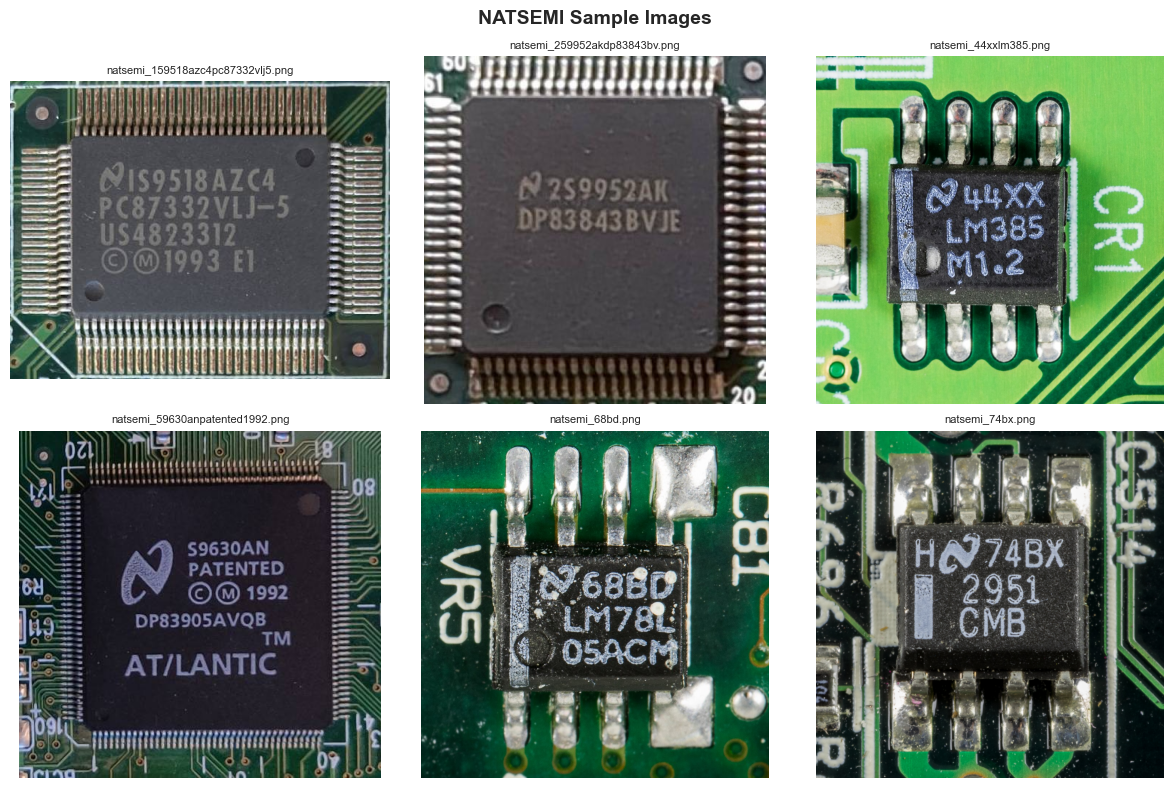


Model predictions for natsemi:

  natsemi_159518azc4pc87332vlj5.png:
    creative: 20.2%
    adaptec: 18.3%
    crystal: 11.5%

  natsemi_259952akdp83843bv.png:
    intel: 25.0%
    fujitsu: 23.9%
    winbond: 14.6%

  natsemi_44xxlm385.png:
    philips: 32.0%
    texas: 20.5%
    stm: 12.4%

  natsemi_59630anpatented1992.png:
    winbond: 19.4%
    creative: 14.7%
    crystal: 11.2%

  natsemi_68bd.png:
    stm: 33.5%
    amd: 15.0%
    analog: 10.7%

Analyzing STM: Found 24 images


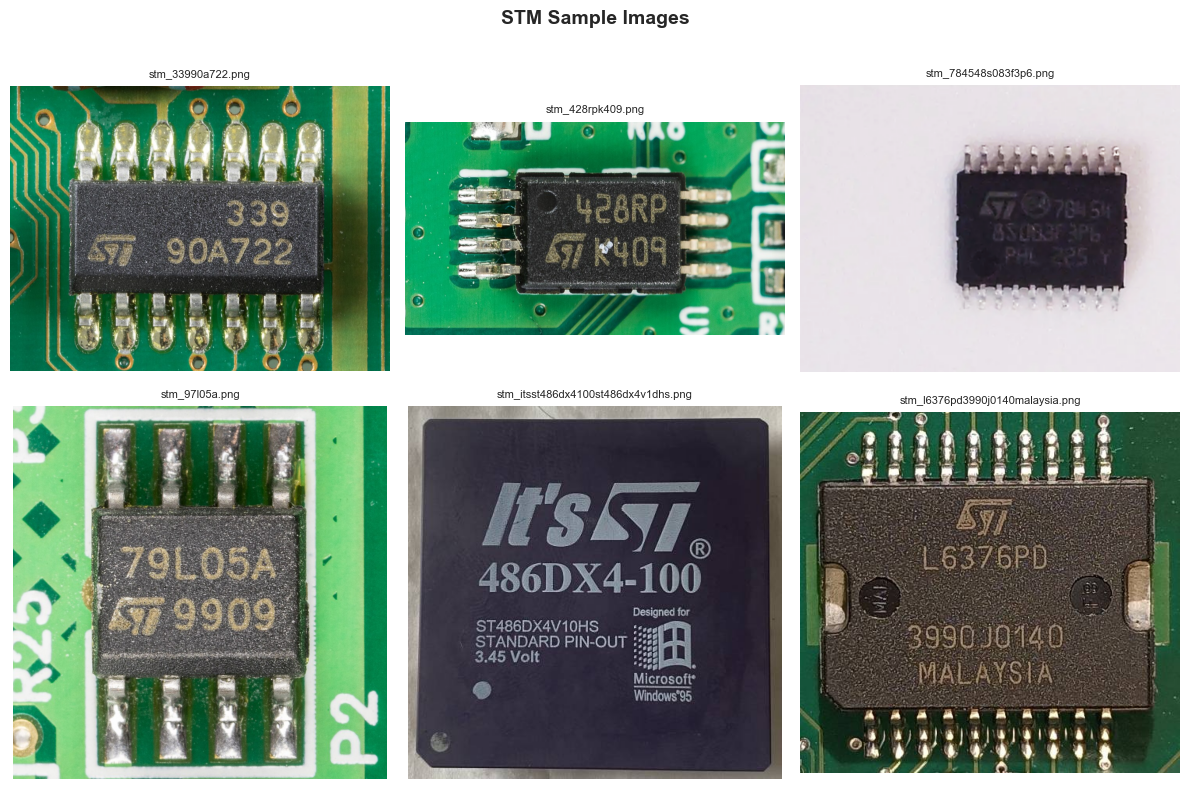


Model predictions for stm:

  stm_33990a722.png:
    stm: 96.2%
    motorola: 1.0%
    texas: 0.8%

  stm_428rpk409.png:
    stm: 96.1%
    amd: 1.5%
    motorola: 0.4%

  stm_784548s083f3p6.png:
    actel: 44.5%
    microchip: 19.9%
    intel: 15.3%

  stm_97l05a.png:
    stm: 96.3%
    motorola: 1.2%
    texas: 0.3%

  stm_itsst486dx4100st486dx4v1dhs.png:
    stm: 91.0%
    creative: 3.7%
    actel: 1.5%


In [10]:
# Diagnostic code for problem brands
import matplotlib.pyplot as plt
from PIL import Image

problem_brands = ['natsemi', 'stm']

for brand in problem_brands:
    # Find all images for this brand
    brand_images = [f for f in os.listdir(DATA_DIR) if f.startswith(f'{brand}_')]
    
    print(f"\n{'='*60}")
    print(f"Analyzing {brand.upper()}: Found {len(brand_images)} images")
    print(f"{'='*60}")
    
    # Show first 6 images
    n_show = min(6, len(brand_images))
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f'{brand.upper()} Sample Images', fontsize=14, fontweight='bold')
    
    for i in range(n_show):
        row = i // 3
        col = i % 3
        
        img_path = os.path.join(DATA_DIR, brand_images[i])
        img = Image.open(img_path)
        
        axes[row, col].imshow(img)
        axes[row, col].set_title(brand_images[i], fontsize=8)
        axes[row, col].axis('off')
    
    # Hide unused subplots
    for i in range(n_show, 6):
        row = i // 3
        col = i % 3
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Check what model predicts for these
    print(f"\nModel predictions for {brand}:")
    for img_file in brand_images[:5]:
        img_path = os.path.join(DATA_DIR, img_file)
        img = Image.open(img_path).convert('RGB')
        img_tensor = val_test_transforms(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(img_tensor)
            probs = F.softmax(output, dim=1)
            top3_probs, top3_idx = torch.topk(probs, 3)
            
            print(f"\n  {img_file}:")
            for prob, idx in zip(top3_probs[0], top3_idx[0]):
                print(f"    {idx_to_brand[idx.item()]}: {prob.item()*100:.1f}%")